### Обучение обратным распостранением на основе датасета iris-ов

In [146]:
import sklearn.datasets
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
from math import ceil
from tqdm import tqdm
import sklearn.metrics
from sklearn.metrics import ConfusionMatrixDisplay

np.set_printoptions(formatter={"float": lambda x: "{0:0.3f}".format(x)})

Загрузка датасета

In [147]:
data_object = sklearn.datasets.load_iris(as_frame=True)
data = data_object.frame
target_names = data_object.target_names
data.sample(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
116,6.5,3.0,5.5,1.8,2
99,5.7,2.8,4.1,1.3,1
111,6.4,2.7,5.3,1.9,2
36,5.5,3.5,1.3,0.2,0
141,6.9,3.1,5.1,2.3,2


Посмотрим зависимости в данных

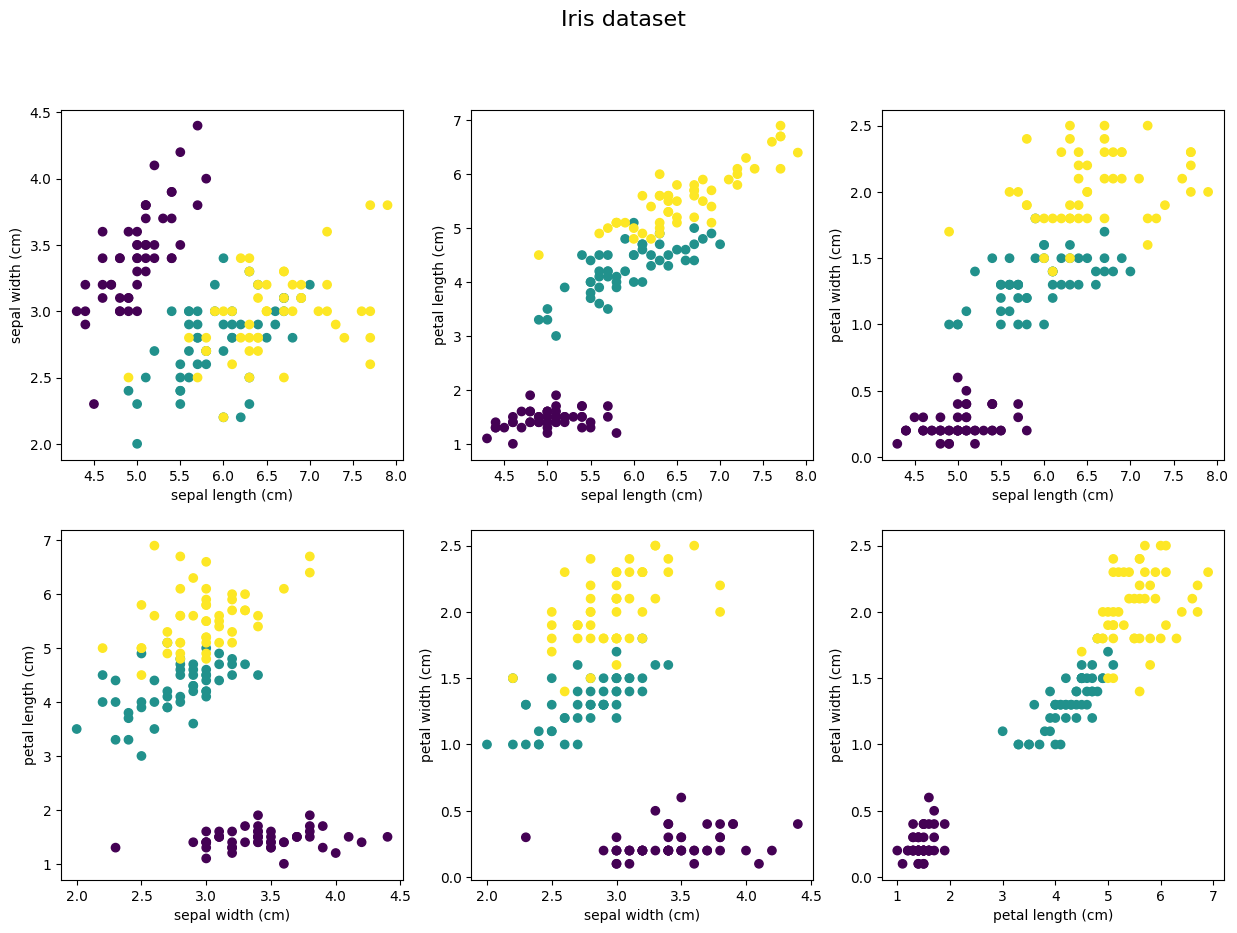

In [148]:
fig, (axes) = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes[0, 0].scatter(data.iloc[:, 0], data.iloc[:, 1], c=data['target'])
axes[0, 0].set_xlabel('sepal length (cm)')
axes[0, 0].set_ylabel('sepal width (cm)')

axes[0, 1].scatter(data.iloc[:, 0], data.iloc[:, 2], c=data['target'])
axes[0, 1].set_xlabel('sepal length (cm)')
axes[0, 1].set_ylabel('petal length (cm)')

axes[0, 2].scatter(data.iloc[:, 0], data.iloc[:, 3], c=data['target'])
axes[0, 2].set_xlabel('sepal length (cm)')
axes[0, 2].set_ylabel('petal width (cm)')

axes[1, 0].scatter(data.iloc[:, 1], data.iloc[:, 2], c=data['target'])
axes[1, 0].set_xlabel('sepal width (cm)')
axes[1, 0].set_ylabel('petal length (cm)')

axes[1, 1].scatter(data.iloc[:, 1], data.iloc[:, 3], c=data['target'])
axes[1, 1].set_xlabel('sepal width (cm)')
axes[1, 1].set_ylabel('petal width (cm)')

axes[1, 2].scatter(data.iloc[:, 2], data.iloc[:, 3], c=data['target'])
axes[1, 2].set_xlabel('petal length (cm)')
axes[1, 2].set_ylabel('petal width (cm)')
fig.suptitle('Iris dataset', fontsize=16)
plt.show()

Предобработаем датасет, номера классов преобразуем при помощи one-hote кодирования

Данные, на которых будет производиться обучение нормализуем в диапазон [0, 1] при помощи min-max преобразования

In [149]:
scaler = sklearn.preprocessing.MinMaxScaler()
X = scaler.fit_transform(data.iloc[:, :4])

encoder = sklearn.preprocessing.OneHotEncoder()
Y = encoder.fit_transform(data['target'].values[:, None]).toarray()

Разобьём выборку на обучающую и валидационную, используем 70% для обучения, также воспользуемся предоставляемой возможностью стратификации на основе классов, чтобы выборка была максимально сбалансированной по количеству классов

In [150]:
train_x, test_x, train_y, test_y = train_test_split(X, Y, train_size=0.7, stratify=data['target'])

len(train_x), len(test_x), len(train_y), len(test_y)

(105, 45, 105, 45)

Реализуем необходимые функции активации нейроной для наших будущих слоёв

In [151]:
from collections import deque
from typing import Callable, Tuple

type Nums = np.ndarray[np.number]
type NumsToNums = Callable[[Nums], Nums]
type NumsNumsToNums = Callable[[Nums, Nums], Nums]

def relu(x: Nums):
    return x * (x > 0)

def drelu(x: Nums):
    # производная функции relu
    return (x > 0)

def sigmoid(x: Nums):
    return 1 / (1 + np.exp(-x))

def dsigmoid(x: Nums):
    s = sigmoid(x)
    return s * (1 - s)

def softmax(x: Nums):
    e_x = np.exp(x)
    sm = np.sum(e_x)
    return e_x / sm

def cross_entropy(z: Nums, y: Nums):
    # z - предсказанное, y - ожидаемое
    return -np.sum(y * np.log(z))

def error_function(pred: Nums, expected: Nums):
    # Получаем ошибку для последнего слоя нейросети
    return pred - expected

Реализуем универсальный класс для линейного слоя

In [152]:
class Layer:
    """
    Реализует линейный слой в многослойном перцептроне

    input_size: int - количество входных нейронов
    output_size: int - количество выходных нейронов
    weights: np.ndarray[np.number] - веса слоя
    bias: np.ndarray[np.number] - смещения
    
    self.activation_function: NumsToNums - функция активации слоя
    self.activation_function_derivation: NumsToNums - производная функции активации слоя
    """

    def __init__(
        self,
        input_size: int,
        output_size: int,
        activation_function: Tuple[
                NumsToNums,
                NumsToNums,
            ],
    ) -> None:
        """
        Args:
            input_size (int): размерность входных данных слоя
            output_size (int): размерность выходных данных слоя
            activation_function (NumsToNums, NumsToNums): кортеж из функции активации и её производной
        """
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.random((input_size, output_size))
        self.bias = np.random.random((1, output_size))
        self.activation_function = activation_function[0]
        self.activation_function_derivation = activation_function[1]
        
        # Значения x и t, фиксируемые при forward, нужны для вычисления ошибки
        self._xt = ()
        """
        Контейнеры для хранения вычисленных ошибок для весов и смещений
        Необходимы для того, чтобы можно было обучать батчами
        
        В батче, для каждого примера необходимо вызвать forward и backward.
        В конце батча, для модификации весов, необходимо вызвать update
        _errors_log будет очищен
        """
        self._errors_log = ([], [])

    def forward(self, x: Nums) -> Nums:
        # линейное преобразование
        t = x @ self.weights + self.bias
        # нелинейное преобразование
        h = self.activation_function(t)
        
        # Записываем значения, необходимые для вычисления ошибки
        self._xt = (x, t)
        return h

    def backward(self, error: Nums) -> Nums:
        """
        Обратное распространение ошибки
        Запоминает производные ошибки, но не изменяет параметры модели
        Для изменения нужно вызвать update
        """
        x, t = self._xt
        self._xt = ()
        
        de_dT = error * self.activation_function_derivation(t)
        de_dW = x.T @ de_dT
        de_dB = de_dT
        de_dX = de_dT @ self.weights.T
        self._errors_log[0].append(de_dW)
        self._errors_log[1].append(de_dB)
        return de_dX
    
    def update(self, learning_rate: float):
        """
        Модифицирует веса модели
        learning_rate: float, [0, 1] - на сколько сильно модель будет реагировать на ошибку
        """
        de_dWs, de_dBs = self._errors_log
        de_dW = np.sum(de_dWs, axis=0)
        de_dB = np.sum(de_dBs, axis=0)
        self.weights -= learning_rate * de_dW
        self.bias -= learning_rate * de_dB
        self._errors_log = ([], [])

    def __repr__(self) -> str:
        return f"<LinearLayer, {self.input_size}x{self.output_size}>"

Соответственно и общий класс для перцептрона с обучением по батчам

In [153]:
from typing import Any


class NN:
    """
    Полносвязная многослойная нейронная сеть
    """
    def __init__(
        self,
        layers: list[Layer],
        loss_function: NumsNumsToNums,
        error_function: NumsNumsToNums,
    ) -> None:
        self.layers = layers
        self.loss_function = loss_function  # Функция потерь
        self.error_function = error_function  # Функция для получения ошибки для последнего слоя
        
        # История значения loss_function, после train
        self.losses = []
        # Предсказания, полученные после train
        self.predicted = []
    
    def pop_loss(self, func: Callable[[Nums], Any]):
        loss = func(self.losses)
        self.losses.clear()
        return loss

    def forward(self, x: Nums) -> Nums:
        """
        Прямое распространение сети
        """
        current_x = x
        for layer in self.layers:
            current_x = layer.forward(current_x)

        return current_x

    def backward(self, error: Nums) -> Nums:
        """
        Обратное распространение сети, не меняет веса
        """
        current_error = error
        
        # Для последнего слоя ошибку получаем в error_function
        for layer in self.layers[::-1]:
            current_error = layer.backward(current_error)

        return current_error

    def update(self, learning_rate):
        """
        Модификация весов сети, все ошибки сохраняются в слои,
        стоит лишь вызвать данную функцию после однократного
        или серии применений (при batch) backward
        """
        for layer in self.layers[::-1]:
            layer.update(learning_rate)

    def train(self, xs: Nums, ys: Nums, learning_rate: float=0.001, batch_size: int=10):
        """
        Обучение сети в рамках одной эпохи
        """
        # Цикл по батчам, размера batch_size
        for batch_index in range(ceil(len(xs) / batch_size)):
            current_batch_slice = slice(
                batch_index * batch_size, (batch_index + 1) * batch_size
            )
            batch_xs = xs[current_batch_slice]
            batch_ys = ys[current_batch_slice]
            batch_losses = []  # Loss-ы одного батча

            for x, y in zip(batch_xs, batch_ys):
                x = x[None, ...]  # Для правильных размерностей (1, n), а не (n,)
                predict = self.forward(x)[0]
                error = self.error_function(predict, y)
                
                # Считаем ошибку
                self.backward(error)
                
                E = self.loss_function(predict, y)
                self.predicted.append(predict)
                batch_losses.append(E)

            # Обновляем веса
            self.update(learning_rate=learning_rate)
            
            # Собираем статистику
            batch_loss = np.sum(batch_losses)
            batch_losses.clear()
            self.losses.append(batch_loss)

Создадим экземпляр нашего перцептрона и обучим его

In [204]:
network = NN(
    [
        Layer(4, 10, (relu, drelu)),
        Layer(10, 3, (softmax, lambda x: x))  # x -> x - транзитом, не считаем производную
    ],
    loss_function=cross_entropy,
    error_function=error_function,
)

def train(network: NN, x: Nums, y: Nums, num_epoches: int, learning_rate: float, batch_size: int):
    bar = tqdm(range(1, num_epoches + 1), total=num_epoches)
    xy_indices = np.arange(len(x))
    loss_history = []
    for epoch in bar:
        network.predicted.clear()
        # В каждой эпохе изменим порядок обучающего датасета
        np.random.shuffle(xy_indices)
        epoch_x = x[xy_indices]
        epoch_y = y[xy_indices]
        network.train(epoch_x, epoch_y, learning_rate=learning_rate, batch_size=batch_size)
        
        loss = network.pop_loss(np.min)
        loss_history.append(loss)
        y_pred_classes = np.argmax(network.predicted, axis=1)
        y_true_classes = np.argmax(epoch_y, axis=1)

        acc = sklearn.metrics.accuracy_score(y_true_classes, y_pred_classes)
        f1 = sklearn.metrics.f1_score(y_true_classes, y_pred_classes, average='weighted')
        
        bar.set_description(f"epoch: {epoch}, loss: {loss:.10f}, acc: {acc:.3f}, f1: {f1:.3f}")
        network.losses.clear()
    return loss_history

loss_history = train(network, train_x, train_y, 100, 0.007, 1)

epoch: 100, loss: 0.0000098048, acc: 0.962, f1: 0.962: 100%|██████████| 100/100 [00:01<00:00, 66.62it/s]


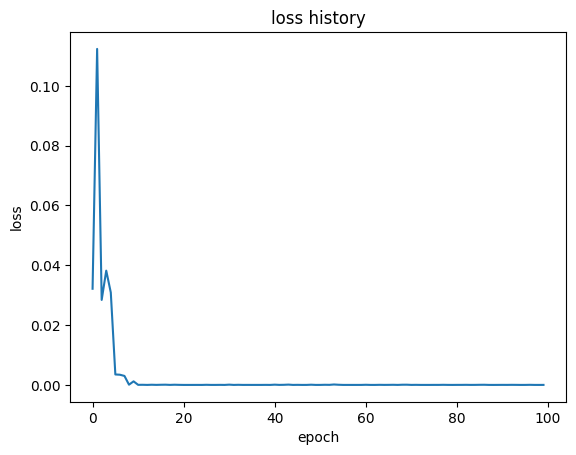

In [205]:
fig, ax = plt.subplots()

ax.plot(loss_history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_title("loss history")
plt.show()

Посмотрим на результат обучения на валидационной выборке

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       1.00      0.93      0.97        15
   virginica       0.94      1.00      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



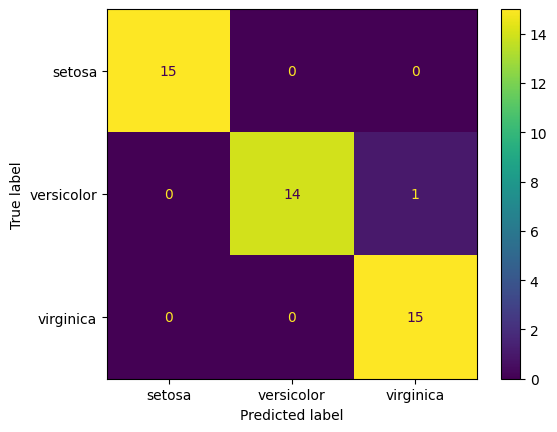

In [206]:
y_pred = network.forward(test_x)

y_pred_classes = [target_names[x] for x in np.argmax(y_pred, axis=1)]
y_true_classes = [target_names[x] for x in np.argmax(test_y, axis=1)]

print(sklearn.metrics.classification_report(y_true_classes, y_pred_classes))
ConfusionMatrixDisplay.from_predictions(y_true_classes, y_pred_classes)

Ура!

Если влом эксперементировать с параметрами, пускай за нас это делает компьютер

In [162]:
import optuna

def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.01, step=0.001)
    batch_size = trial.suggest_int('batch_size', 1, 5)
    hidden_neurons_count = trial.suggest_int('hidden_neurons_count', 5, 15)
    use_sigmoid = trial.suggest_categorical('use_sigmoid', [True, False])
    epoche_count = trial.suggest_int('epoche_count', 30, 300, log=True)
    
    if use_sigmoid:
        activation_function = (sigmoid, dsigmoid)
    else:    
        activation_function = (relu, drelu)
    
    network = NN(
        [
            Layer(4, hidden_neurons_count, activation_function),
            Layer(hidden_neurons_count, 3, (softmax, lambda x: x))
        ],
        loss_function=cross_entropy,
        error_function=error_function,
    )
    
    train(
        network,
        train_x,
        train_y,
        epoche_count,
        learning_rate=learning_rate,
        batch_size=batch_size
    )
    
    # Проверяем F1 на валидационной выборке
    y_pred = network.forward(test_x)

    y_pred_classes = [target_names[x] for x in np.argmax(y_pred, axis=1)]
    y_true_classes = [target_names[x] for x in np.argmax(test_y, axis=1)]
    
    f1_validation = sklearn.metrics.f1_score(y_true_classes, y_pred_classes, average='weighted')
    return f1_validation, epoche_count

In [166]:
study = optuna.create_study(directions=["maximize", "minimize"])
study.optimize(objective, n_trials=100)

[I 2024-11-25 13:08:10,550] A new study created in memory with name: no-name-0887d5c2-77a7-47b6-bb3a-0e37f829695f
epoch: 208, loss: 0.0012455381, acc: 0.990, f1: 0.990: 100%|██████████| 208/208 [00:02<00:00, 88.20it/s]
[I 2024-11-25 13:08:12,915] Trial 0 finished with values: [0.9553571428571429, 208.0] and parameters: {'learning_rate': 0.009000000000000001, 'batch_size': 3, 'hidden_neurons_count': 5, 'use_sigmoid': True, 'epoche_count': 208}.
epoch: 74, loss: 0.0029617510, acc: 0.952, f1: 0.952: 100%|██████████| 74/74 [00:00<00:00, 94.32it/s]
[I 2024-11-25 13:08:13,707] Trial 1 finished with values: [0.9553571428571429, 74.0] and parameters: {'learning_rate': 0.003, 'batch_size': 3, 'hidden_neurons_count': 6, 'use_sigmoid': False, 'epoche_count': 74}.
epoch: 41, loss: 1.1049589167, acc: 0.676, f1: 0.660: 100%|██████████| 41/41 [00:00<00:00, 93.07it/s]
[I 2024-11-25 13:08:14,153] Trial 2 finished with values: [0.5555555555555556, 41.0] and parameters: {'learning_rate': 0.002, 'batch_si

In [169]:
study.best_trials[0].params

{'learning_rate': 0.009000000000000001,
 'batch_size': 2,
 'hidden_neurons_count': 13,
 'use_sigmoid': False,
 'epoche_count': 31}

In [168]:
df = study.trials_dataframe()
df.to_csv("optuna_results.csv", index=False)